In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from src.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from src.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from src.utils import visualize_boxes, visualize_outputs, plot_grid_anchors
from src.postprocessing import bbox_iou, decode_model_outputs, non_max_suppression, NMS
from src.callbacks import create_callbacks
from models.bbox_preprocess import TransformBoxes
from models.loss import lossFunction
from models.model import Mean, MyModel, make_dummy_model
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys
from models.config import *

# Load Data

In [3]:
ds_train = load_coco_dataset(args, coco_val_ds_path, augment_func = None, split = 'train') ######################### USE VAL FOR NOW AS TRAIN IS LONG
# ds_train = load_voc_dataset(args, voc_train_ds_path, None, 'train')

Loading train dataset from D:\DL-CV-ML Projects\Turion_Space\Object Detection\data\COCO_data_val.tfrecord...


In [4]:
tmvm = iter(ds_train)

In [5]:
kvsdk = next(tmvm)

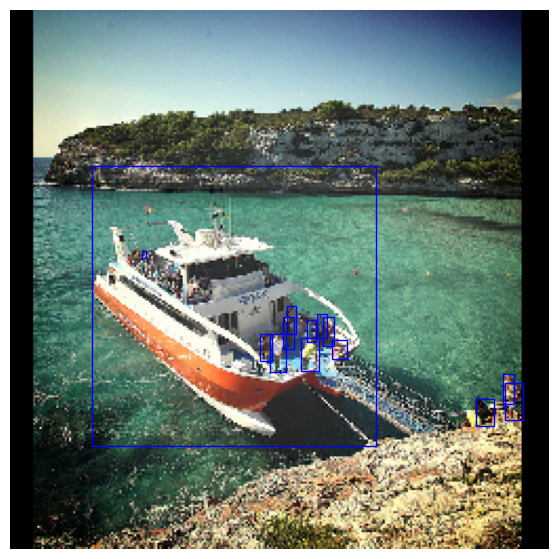

In [6]:
i = 0
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [7]:
setup_bboxes = TransformBoxes(args, grid_sizes, norm_anchors)

In [8]:
grid = setup_bboxes(kvsdk[1])

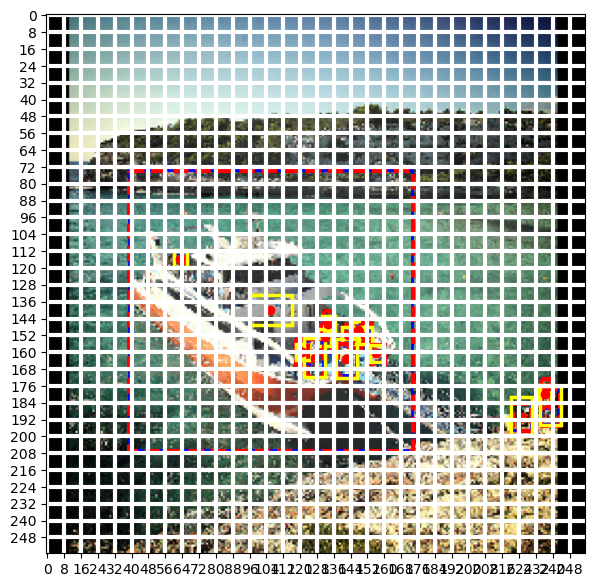

Total bboxes: 14, Total anchors: 14


In [11]:
c = 2
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (7, 7), norm_anchors[c], False, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Make Sure Augmentations Work

In [12]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [13]:
augmenter.update(tf.constant(0.5))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.2496521]], dtype=float32)>


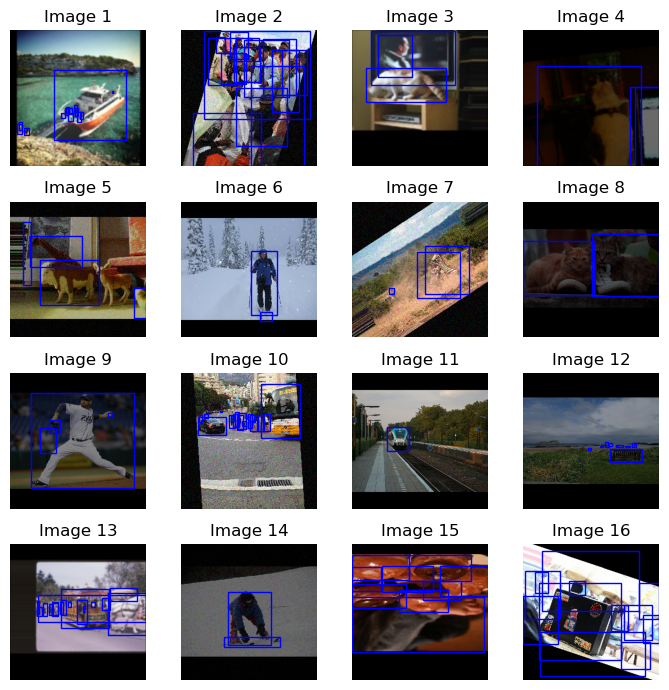

In [14]:
scale = tf.constant([args.img_size[0], args.img_size[1], args.img_size[0], args.img_size[1]], dtype=tf.float32)
visualize_outputs(test_ada[0], test_ada[1][..., :-1], scale=scale, figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [15]:
grid2 = setup_bboxes(test_ada[1])

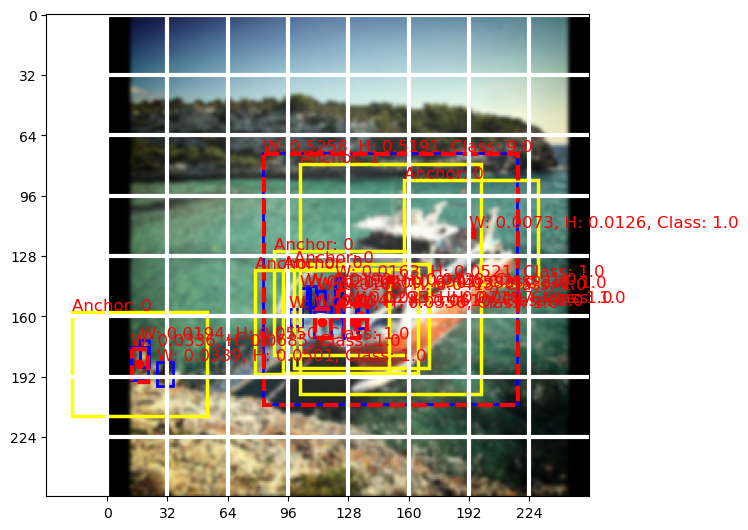

Total bboxes: 14, Total anchors: 7


In [16]:
c = 0
indx = 0
plot_grid_anchors(test_ada[0][indx], test_ada[1][indx], grid2[c][indx], (7, 7), norm_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Train

In [17]:
def make_dummy_model(img_size, grid_sizes, classes = 100, num_anchors = 3):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN1')(x)
    x = layers.Activation("relu", name='Act1')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv2')(x)
    x = layers.BatchNormalization(name='BN2')(x)
    x = layers.Activation("relu", name='Act2')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv3')(x)
    x = layers.BatchNormalization(name='BN3')(x)
    x = layers.Activation("relu", name='Act3')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", name='Conv4')(x)
    x = layers.BatchNormalization(name='BN4')(x)
    x = layers.Activation("relu", name='Act4')(x)

    filters = num_anchors * (4 + 1 + classes)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv1')(x)
    out1 = layers.Reshape((grid_sizes[0], grid_sizes[0], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv2')(x)
    out2 = layers.Reshape((grid_sizes[1], grid_sizes[1], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv3')(x)
    out3 = layers.Reshape((grid_sizes[2], grid_sizes[2], num_anchors, classes + 5))(x)

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2, out3])
    return model

In [18]:
def setupModel(args, grid_sizes, anchors, augmentations, save_model_path, config_opt):

    augment_func = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=args.ada_initial_probability, switch=True)
    test_mymodel = MyModel(img_size=args.img_size, augment_func=augment_func, grid_sizes=grid_sizes, anchors=anchors, args=args)

    loss_list = []
    for i in range(anchors.shape[0]):
        loss = lossFunction(anchors[i], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
        loss_list.append(loss)
    callback_list = create_callbacks(save_model_path, args, test_mymodel, anchors, img_path = r'D:\DL-CV-ML Projects\Turion_Space\Updated_Turion_Space\imgs\img.png')

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]
        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
        optimizer = optimizer.from_config(config=config_opt)

    else:
        optimizer = tf.keras.optimizers.get(args.optimizer)
        optimizer = optimizer.from_config(config=config_opt)

    return test_mymodel, loss_list, callback_list, optimizer

In [19]:
test_mymodel, loss_list, callbacks_list, optimizer = setupModel(args, grid_sizes, norm_anchors, augmentations, save_model_path, config_opt)

In [20]:
test_mymodel.compile(optimizer=optimizer, metrics = [Mean(name="aug_probability")], loss=loss_list)

Epoch 1/5


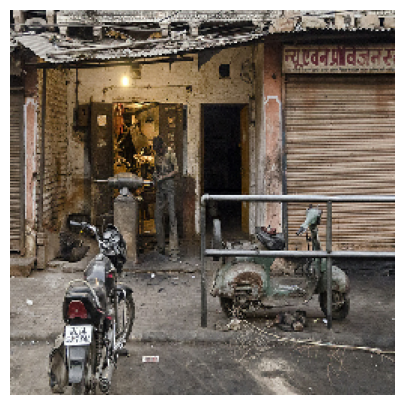

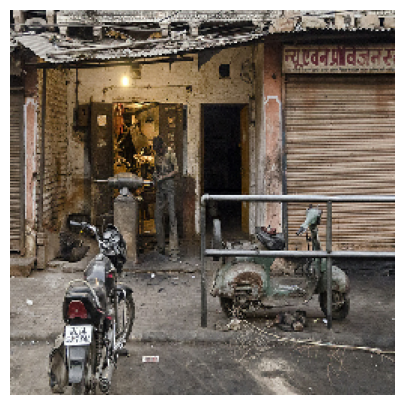

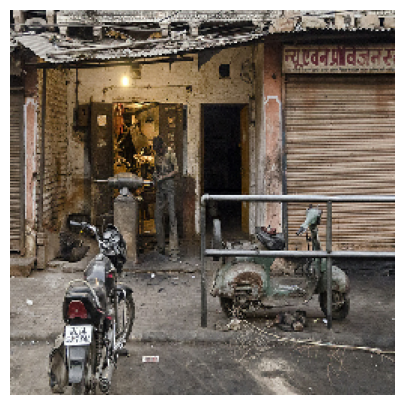

312/312 [==============================] - 95s 256ms/step - loss: 129.3002 - output_1_loss: 38.9256 - output_2_loss: 44.0802 - output_3_loss: 46.2944 - aug_probability: 0.0296 - iou_tracker: 0.1031

Epoch 1: loss improved from inf to 129.3001708984375, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 2/5
312/312 [==============================] - 82s 262ms/step - loss: 117.7082 - output_1_loss: 36.0011 - output_2_loss: 42.0646 - output_3_loss: 39.6424 - aug_probability: 0.0289 - iou_tracker: 0.1007

Epoch 2: loss improved from 129.3001708984375 to 117.70816802978516, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 3/5


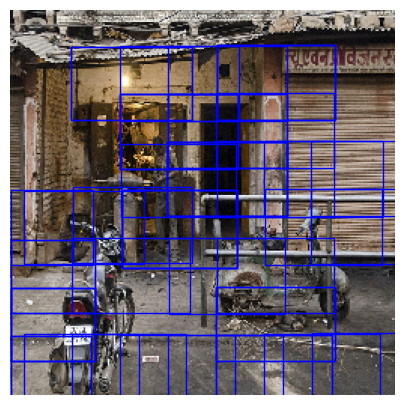

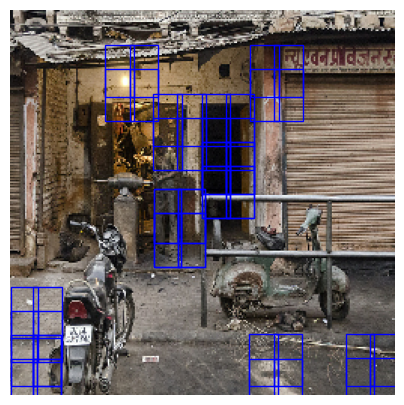

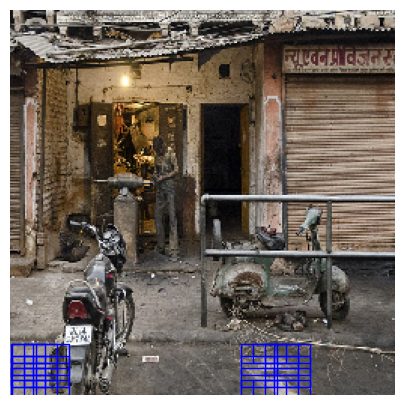

312/312 [==============================] - 85s 267ms/step - loss: 114.8602 - output_1_loss: 34.9943 - output_2_loss: 41.4106 - output_3_loss: 38.4553 - aug_probability: 0.0304 - iou_tracker: 0.1052

Epoch 3: loss improved from 117.70816802978516 to 114.86017608642578, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 4/5
312/312 [==============================] - 79s 252ms/step - loss: 112.9428 - output_1_loss: 34.3267 - output_2_loss: 41.0552 - output_3_loss: 37.5608 - aug_probability: 0.0314 - iou_tracker: 0.1084

Epoch 4: loss improved from 114.86017608642578 to 112.94281005859375, saving model to D:\DL-CV-ML Projects\Turion_Space\Object Detection\Object Detection\model_weights\model.h5
Epoch 5/5
312/312 [==============================] - 83s 266ms/step - loss: 112.0129 - output_1_loss: 33.9056 - output_2_loss: 40.9459 - output_3_loss: 37.1613 - aug_probability: 0.0324 - iou_tracker: 0.1113

Epoch 5: loss improved from 1

In [21]:
test_mymodel.fit(ds_train, epochs=5, callbacks=callbacks_list)